## 과제 내용
### 'Standford dogs' 데이터셋을 증강 없이, 일반 증강 있이, CutMix사용, Mixup사용을 통해 증강기법을 적용해보자.

## 전체 작업흐름
### 1.라이브러리 준비
### 2.기본 필수 요소 준비(결과 시각화 그래프 저장 함수, 계속 쓰이는 데이터 준비, 모델 정의, 공통 전처리)
### 3.공통 모델 정의 및 모델 컴파일 및 훈련 방법 정의
### 4.각 기법 함수 정의, 사용 및 훈련
### 5.결과 저장 및 비교

## 라이브러리 준비

In [58]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import urllib3
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
import os
urllib3.disable_warnings()

In [59]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 시각화 그래프

In [60]:
# 시각화 그래프
def plot_training_history(history, Augmentation='None', save_dir='./'):
    os.makedirs(save_dir, exist_ok=True)

    # Loss 시각화
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{Augmentation} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f'{Augmentation}_Loss.png'))
    plt.close()

    # Accuracy 시각화
    if 'accuracy' in history.history or 'val_accuracy' in history.history:
        plt.plot(history.history.get('accuracy', []), label='train_accuracy')
        plt.plot(history.history.get('val_accuracy', []), label='val_accuracy')
        plt.title(f'{Augmentation}_Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, f'{Augmentation}_Accuracy.png'))
        plt.close()

## 데이터 로드

In [61]:
# 원본 데이터에 대한 학습
# 60% train, 40% validation, 실제 test는 별도로 인터넷 이미지를 가져와 사용할 예정
(ds_train, ds_val), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## 전처리 및 라벨링

In [62]:
import pandas as pd

def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

# 기본 전처리

# 전처리 함수 정의
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=32, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_original = apply_normalize_on_dataset(ds_train, batch_size=32, is_test=False)
val_original = apply_normalize_on_dataset(ds_val, batch_size=32, is_test=True)

## 오류방지

In [63]:
strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## 모델 정의, 모델 컴파일 및 훈련 정의

In [64]:
from tensorflow.keras.applications import ResNet50

num_classes = ds_info.features["label"].num_classes

# 기성님 코드(에러가 너무 많이 나서 완성된 코드 씀)
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

def compile_and_fit(resnet50,
                    ds_train,
                    ds_val,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_val,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

## 기본 모델 훈련

In [8]:
resnet50 = create_ResNet50()

EPOCH= 20
LEARNING_RATE=0.01
BATCH_SIZE = 32

history_resnet50_no_aug = compile_and_fit(
    resnet50,
    train_original,
    val_original,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
375/375 [==============================] - 175s 426ms/step - loss: 2.5175 - accuracy: 0.4187 - val_loss: 5.0612 - val_accuracy: 0.0084
Epoch 2/20
375/375 [==============================] - 163s 435ms/step - loss: 0.8638 - accuracy: 0.7742 - val_loss: 3.2307 - val_accuracy: 0.2288
Epoch 3/20
375/375 [==============================] - 163s 435ms/step - loss: 0.4320 - accuracy: 0.8992 - val_loss: 1.0748 - val_accuracy: 0.6818
Epoch 4/20
375/375 [==============================] - 163s 435ms/step - loss: 0.1967 - accuracy: 0.9660 - val_loss: 0.9446 - val_accuracy: 0.7186
Epoch 5/20
375/375 [==============================] - 163s 434ms/step - loss: 0.0869 - accuracy: 0.9929 - val_loss: 0.9053 - val_accuracy: 0.7352
Epoch 6/20
375/375 [==============================] - 163s 434ms/step - loss: 0.0517 - accuracy: 0.9973 - val_loss: 0.9186 - val_accuracy: 0.7331
Epoch 7/20
375/375 [==============================] - 163s 434ms/step - loss: 0.0327 - accuracy: 0.9982 - val_loss: 0.9214 -

In [10]:
plot_training_history(history_resnet50_no_aug, Augmentation = 'Plain_pretrained', save_dir='./')

## 증강 함수 정의

In [65]:
# Random Augmentation
def augment(image, label):
    
    # Random Flip (좌우, 상하)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Crop (원본보다 조금 크게 리사이즈 후 랜덤 크롭)
    image = tf.image.resize(image, [256, 256])
    image = tf.image.random_crop(image, size=[224, 224, 3])

    # Random Brightness / Contrast / Saturation / Hue
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)

    # 클리핑 및 정규화
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

## 증강 학습 데이터 준비

In [66]:
# Augmentation 데이터 준비
train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=32,
    is_test=False,
    with_aug=True
)

val_no_aug = apply_normalize_on_dataset(
    ds_val,
    batch_size=32,
    is_test=True
)

## 증강 데이터 학습

In [68]:
resnet50 = create_ResNet50()

# Augmentation Compile 및 학습
history_resnet50_aug = compile_and_fit(
    resnet50,
    train_aug,
    val_no_aug,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
375/375 [==============================] - 173s 403ms/step - loss: 3.2651 - accuracy: 0.2558 - val_loss: 5.0207 - val_accuracy: 0.0091
Epoch 2/20
375/375 [==============================] - 150s 400ms/step - loss: 1.6789 - accuracy: 0.5381 - val_loss: 2.6906 - val_accuracy: 0.3088
Epoch 3/20
375/375 [==============================] - 150s 400ms/step - loss: 1.2556 - accuracy: 0.6447 - val_loss: 1.4628 - val_accuracy: 0.5840
Epoch 4/20
375/375 [==============================] - 150s 401ms/step - loss: 1.0462 - accuracy: 0.6991 - val_loss: 2.3788 - val_accuracy: 0.4074
Epoch 5/20
375/375 [==============================] - 150s 400ms/step - loss: 0.8728 - accuracy: 0.7440 - val_loss: 1.4854 - val_accuracy: 0.5773
Epoch 6/20
375/375 [==============================] - 150s 400ms/step - loss: 0.7210 - accuracy: 0.7936 - val_loss: 1.5705 - val_accuracy: 0.5723
Epoch 7/20
375/375 [==============================] - 150s 401ms/step - loss: 0.6369 - accuracy: 0.8163 - val_loss: 1.5441 -

In [71]:
plot_training_history(history_resnet50_aug, Augmentation = 'Augmentation', save_dir='./')

## Cutmix 함수 정의

In [19]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max
    
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img
    
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label
    
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## CutMix 데이터셋 준비

In [21]:
train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=32,
    is_test=False,
    with_cutmix=True
)

val_no_aug = apply_normalize_on_dataset(
    ds_val,
    batch_size=32,
    is_test=True
)

## CutMix 학습

In [22]:
resnet50 = create_ResNet50()

history_resnet50_cutmix = compile_and_fit(
    resnet50,
    train_cutmix,
    val_no_aug,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
375/375 [==============================] - 163s 251ms/step - loss: 4.2356 - accuracy: 0.1288 - val_loss: 5.3585 - val_accuracy: 0.0073
Epoch 2/20
375/375 [==============================] - 93s 248ms/step - loss: 3.3040 - accuracy: 0.3280 - val_loss: 3.0973 - val_accuracy: 0.2470
Epoch 3/20
375/375 [==============================] - 93s 249ms/step - loss: 2.9500 - accuracy: 0.4437 - val_loss: 1.6832 - val_accuracy: 0.5399
Epoch 4/20
375/375 [==============================] - 93s 247ms/step - loss: 2.7630 - accuracy: 0.4973 - val_loss: 1.4873 - val_accuracy: 0.5942
Epoch 5/20
375/375 [==============================] - 93s 248ms/step - loss: 2.6400 - accuracy: 0.5343 - val_loss: 1.4345 - val_accuracy: 0.6138
Epoch 6/20
375/375 [==============================] - 93s 248ms/step - loss: 2.6343 - accuracy: 0.5298 - val_loss: 1.3330 - val_accuracy: 0.6305
Epoch 7/20
375/375 [==============================] - 93s 248ms/step - loss: 2.4455 - accuracy: 0.5942 - val_loss: 1.2801 - val_a

In [24]:
plot_training_history(history_resnet50_cutmix, Augmentation = 'Cutmix', save_dir='./')

## Mixup 함수 정의

In [47]:
num_classes = ds_info.features["label"].num_classes

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup 데이터셋 준비

In [48]:
train_mixup = apply_normalize_on_dataset(
    ds_train,
    batch_size=32,
    is_test=False,
    with_mixup=True
)

val_no_aug = apply_normalize_on_dataset(
    ds_val,
    batch_size=32,
    is_test=True
)

## Mixup 학습

In [49]:
resnet50 = create_ResNet50()

history_resnet50_mixup = compile_and_fit(
    resnet50,
    train_mixup,
    val_no_aug,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
375/375 [==============================] - 103s 250ms/step - loss: 2.0408 - accuracy: 0.7800 - val_loss: 1.2226 - val_accuracy: 0.6834
Epoch 2/20
375/375 [==============================] - 93s 249ms/step - loss: 2.0293 - accuracy: 0.7880 - val_loss: 1.3305 - val_accuracy: 0.6545
Epoch 3/20
375/375 [==============================] - 93s 249ms/step - loss: 2.0105 - accuracy: 0.7907 - val_loss: 1.2871 - val_accuracy: 0.6674
Epoch 4/20
375/375 [==============================] - 93s 249ms/step - loss: 1.9521 - accuracy: 0.8195 - val_loss: 1.4344 - val_accuracy: 0.6341
Epoch 5/20
375/375 [==============================] - 93s 249ms/step - loss: 1.9464 - accuracy: 0.8100 - val_loss: 1.4588 - val_accuracy: 0.6477
Epoch 6/20
375/375 [==============================] - 93s 249ms/step - loss: 1.9205 - accuracy: 0.8175 - val_loss: 1.2610 - val_accuracy: 0.6781
Epoch 7/20
375/375 [==============================] - 93s 248ms/step - loss: 1.9135 - accuracy: 0.8225 - val_loss: 1.2838 - val_a

In [51]:
plot_training_history(history_resnet50_mixup, Augmentation = 'Mixup', save_dir='./')

## 최종 결과 비교

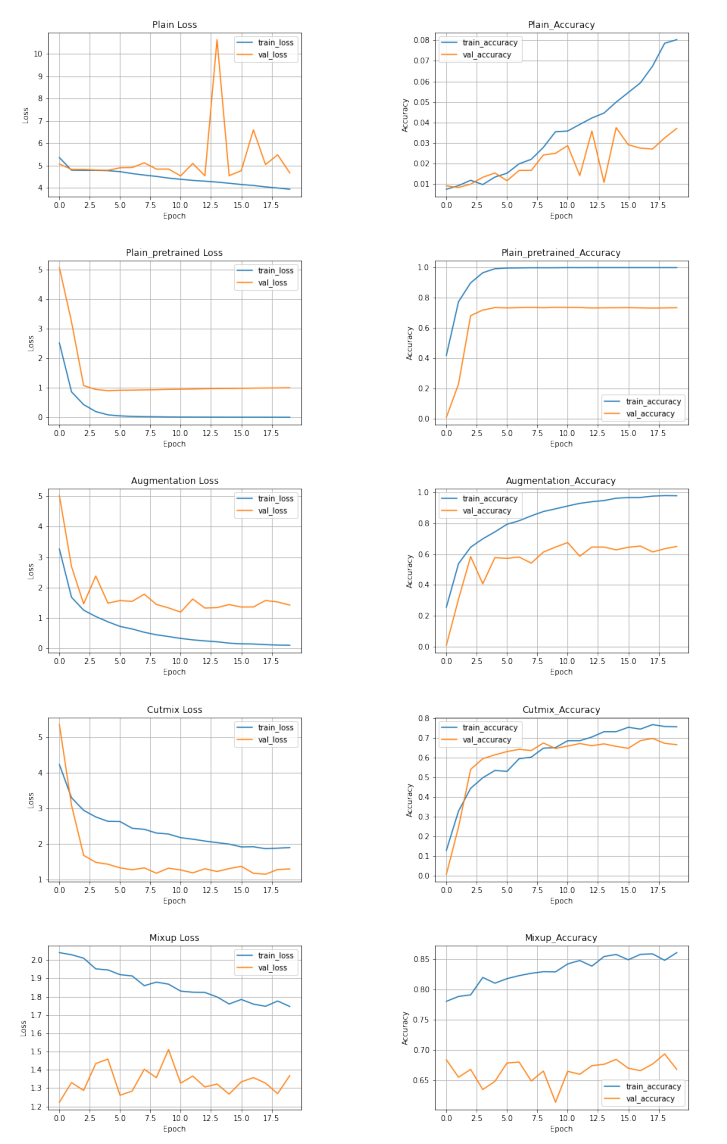

In [73]:
# 그래프를 통한 비교

import matplotlib.pyplot as plt
from PIL import Image


image_paths = [
    "./Plain_Loss.png",
    "./Plain_Accuracy.png",
    "./Plain_pretrained_Loss.png",
    "./Plain_pretrained_Accuracy.png",
    "./Augmentation_Loss.png",
    "./Augmentation_Accuracy.png",
    "./Cutmix_Loss.png",
    "./Cutmix_Accuracy.png",
    "./Mixup_Loss.png",
    "./Mixup_Accuracy.png",
    
]

fig, axes = plt.subplots(5, 2, figsize=(12, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_paths):
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

## 회고
### 1.본 코드에서는 헷갈림 방지로 지웠지만, scratch부터 만든 Resnet50 모델을 사용했을 때 결과가 너무 안 좋았다.
### 2.모델과 데이터셋이 너무 무거워서 학습을 돌리는데 시간이 너무 오래 걸렸다.
### 3.augmentation 결과 저장할 때, 변수를 잘못 써서 다시 돌렸다. 매우 비효율적인 방법이다. 결과를 저장하는 다른 방법 고안이 필요하다.
### 4.augmentation 기법을 잘못 적용하면, 결과가 오히려 안 좋아질 수도 있다.
### 5.Mixup은 최악의 결과를 보여주었는데, 합성 비율을 적절하게 조절해보는 시도를 해볼만 할 것 같다.(예 : 0.3과 0.7)
### 6.CutMix는 단순히 CutMix만 한 데이터만을 훈련데이터로 사용해서 더 안 좋은 결과가 나온 것 같다.
### 7.CutMix는 augmentation의 목접에 부합한 걸로 보인다. 원본 데이터 중 일부를 CutMix로 사용한다면 일반화 성능 증가를 기대할 수도 있다고 판단한다.
### 8.모델을 중간 상태를 저장하는 코드를 써야겠다.
### 9.클래스 당 데이터 개수의 절대적인 부족(20000/120에 근사)으로 인해, 추가 실험을 한다면 원본 데이터+CutMix(적절 바운딩 영역 설정)+Mixup(적절 비율 설정)+단순 Augmentation 데이터로 데이터 수 자체를 증강해서 실험한다면 성능이 개선될 수도 있지 않을까 예상한다.